# Power measurements
- **Length in ns**. Converted to `SP_POINTS = length / 2.5ns`
- **Repetitions**. Split up into batches of `R_POINTS` (rounded to 1000 for optimised kernel performance) to the digitiser.

SP-DIGITISER:   🕱 Disconnected from digitiser.
POWER-PIPELINE: Building kernel with:
R_POINTS=64000
SP_POINTS=800
POWER-PIPELINE: Performing 16 runs (to acquire 1000000 averages)
🗑  Cleaning build objects
removed ‘./build/src/logging.o’
removed ‘./build/src/power_kernel_cpu.o’
removed ‘./build/src/power_kernel_gpu.o’
removed ‘./build/src/power_kernel_gpu_utils.o’
removed ‘./build/src/power_pipeline.o’
removed ‘./build/src/progress_bar.o’
removed ‘./build/src/sp_digitiser.o’
removed ‘./build/src/utils_gpu.o’
removed ‘./build/src/utils.o’
✅ [***] Done

Using flags: -D PYTHON=1 -D SP_POINTS=800 -D R_POINTS=64000 -D R_POINTS_PER_CHUNK=1000

🍕 [cpp] Building src/utils.cpp ⟶ build/./src/utils.o
🍕 [cpp] Building src/sp_digitiser.cpp ⟶ build/./src/sp_digitiser.o
🍕 [cpp] Building src/progress_bar.cpp ⟶ build/./src/progress_bar.o
🍕 [cpp] Building src/power_kernel_gpu_utils.cpp ⟶ build/./src/power_kernel_gpu_utils.o
🍕 [cpp] Building src/utils_gpu.cpp ⟶ build/./src/utils_gpu.o
🍕 [cpp] Building src

<IPython.core.display.Javascript object>


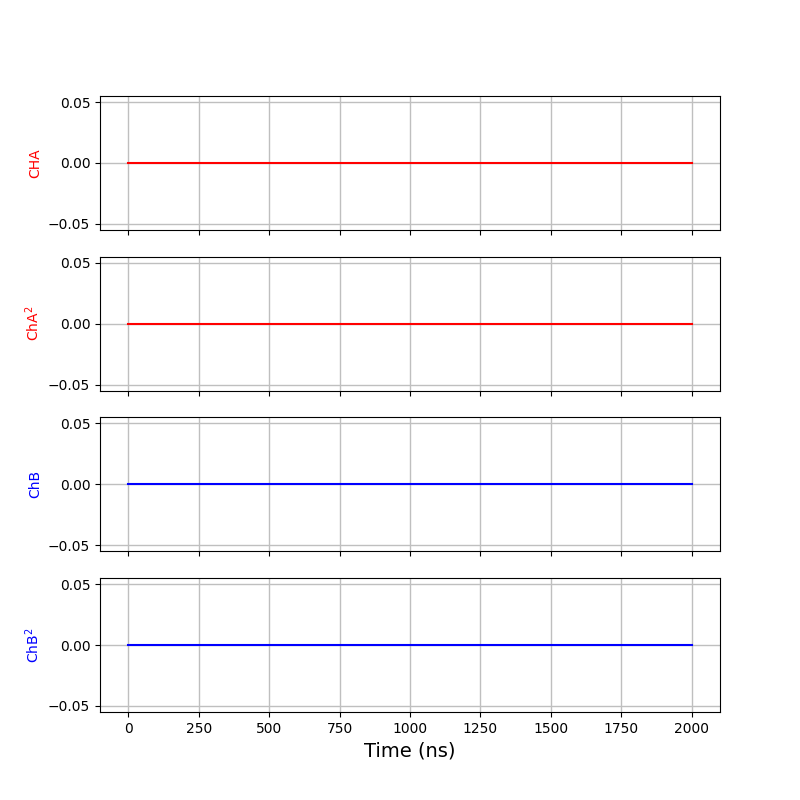

In [1]:
from python_app.sp_digitiser import SpDigitiser
from python_app.power_pipeline import PowerPipeline
%matplotlib notebook

TIME_IN_NS = 2000  # ns
AVERAGES = 1_000_000

pp = PowerPipeline(TIME_IN_NS, AVERAGES)

In [ ]:
pp.execute_run(
    digitiser_parameters={
        "delay": 0,
        "trigger_type": SpDigitiser.TRIGGER_EXTERNAL,
        #     "trigger_type": SpDigitiser.TRIGGER_SOFTWARE,
        "channelA_gain": 1,
        "channelB_gain": 1,
        "channelA_offset": 0,
        "channelB_offset": 0,
        "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_INTERNAL_10MHZ_REFFERENCE,
        "frequency_mode": SpDigitiser.HIGH_FREQUENCY_MODE
    },
    run_name="ttt"
)

SP-DIGITISER:   Trigger frequency: 340kHz
POWER-PIPELINE: Measurements started


In [ ]:
# Kernel must be relaunched if running in jupyter notebook in order to free the dll library being used
os._exit(0)

In [1]:
%matplotlib notebook
import subprocess
import os
import ctypes
import math
import threading
import time

import numpy as np
from matplotlib import pyplot as plt
from watchdog.observers import Observer

from python_app.utils import gpu_utils
from python_app.sp_digitiser import SpDigitiser
from python_app.utils import library_manager
from python_app.utils.file_watcher import PlotTrigger

In [3]:
TIME_IN_NS = 2000 #ns
AVERAGES = 1_000_000_000

R_POINTS_PER_CHUNK = 1000
NO_STREAMS = 2

# Derived
SP_POINTS = math.ceil(TIME_IN_NS / 2.5)
R_POINTS = math.floor(
    SpDigitiser(None).get_max_noRecords_from_noSamples(SP_POINTS)
    / (NO_STREAMS * R_POINTS_PER_CHUNK)) * R_POINTS_PER_CHUNK * NO_STREAMS
NO_RUNS = math.ceil(AVERAGES / R_POINTS)

chA_background = np.zeros(SP_POINTS, dtype=np.short)
chB_background = np.zeros(SP_POINTS, dtype=np.short)

# Report
print(f"Building kernel with: R_POINTS_PER_CHUNK={R_POINTS_PER_CHUNK}, R_POINTS={R_POINTS}, SP_POINTS={SP_POINTS}")
print(f"Performing {NO_RUNS} runs (to acquire {AVERAGES} averages)")

SP-DIGITISER:   🕱 Disconnected from digitiser.
Building kernel with: R_POINTS_PER_CHUNK=1000, R_POINTS=64000, SP_POINTS=800
Performing 15625 runs (to acquire 1000000000 averages)


In [4]:
library_manager.build_library(
    {
        "R_POINTS_PER_CHUNK": f"{R_POINTS_PER_CHUNK}",
        "SP_POINTS": f"{SP_POINTS}",
        "R_POINTS": f"{R_POINTS}",
    }
)

🗑  Cleaning build objects
removed ‘./build/src/logging.o’
removed ‘./build/src/power_kernel_cpu.o’
removed ‘./build/src/power_kernel_gpu.o’
removed ‘./build/src/power_kernel_gpu_utils.o’
removed ‘./build/src/power_pipeline.o’
removed ‘./build/src/progress_bar.o’
removed ‘./build/src/sp_digitiser.o’
removed ‘./build/src/utils_gpu.o’
removed ‘./build/src/utils.o’
✅ [***] Done

Using flags: -D PYTHON=1 -D SP_POINTS=800 -D R_POINTS=64000 -D R_POINTS_PER_CHUNK=1000

🍕 [cpp] Building src/utils.cpp ⟶ build/./src/utils.o
🍕 [cpp] Building src/sp_digitiser.cpp ⟶ build/./src/sp_digitiser.o
🍕 [cpp] Building src/progress_bar.cpp ⟶ build/./src/progress_bar.o
🍕 [cpp] Building src/power_kernel_gpu_utils.cpp ⟶ build/./src/power_kernel_gpu_utils.o
🍕 [cpp] Building src/utils_gpu.cpp ⟶ build/./src/utils_gpu.o
🍕 [cpp] Building src/power_kernel_cpu.cpp ⟶ build/./src/power_kernel_cpu.o
🍕 [cpp] Building src/logging.cpp ⟶ build/./src/logging.o
🍕 [cpp] Building src/power_pipeline.cpp ⟶ build/./src/power_pipelin

In [5]:
libia = ctypes.cdll.LoadLibrary("./csrc/bin/libia.so")

# Check parameters that kernel was compiled with - some checks are easier to do in python.
libia.check_power_kernel_parameters()
gpu_utils.check_gpu_allocation(
    **{
        "grid_dim_x": libia.fetch_power_kernel_blocks(),
        "block_dim_x": libia.fetch_power_kernel_threads()
    }
)

In [6]:
spd = SpDigitiser({
    "r_points": R_POINTS,
    "sp_points": SP_POINTS,
    "delay": 0,
    "trigger_type": SpDigitiser.TRIGGER_EXTERNAL,
#     "trigger_type": SpDigitiser.TRIGGER_SOFTWARE,
    "channelA_gain": 1,
    "channelB_gain": 1,
    "channelA_offset": 0,
    "channelB_offset": 0,
    "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_INTERNAL_10MHZ_REFFERENCE,
    "frequency_mode": SpDigitiser.HIGH_FREQUENCY_MODE
})

SP-DIGITISER:   Trigger frequency: 340kHz


<IPython.core.display.Javascript object>


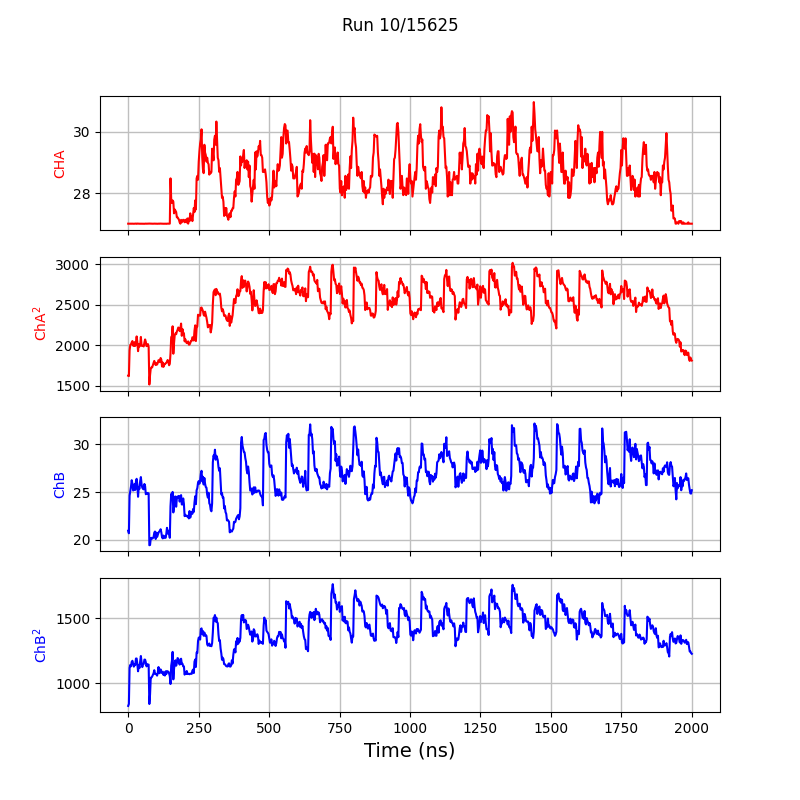

In [7]:
# idx is the data index in array
# ax is plot location
plots = {
    "CHA": {
        "idx": 0, "ax":0, "color": "red", "label": "CHA"
    },
    "CHASQ": {
        "idx": 2, "ax":1, "color": "red", "label": "ChA$^2$"
    },
    "CHB": {
        "idx": 1, "ax":2, "color": "blue", "label": "ChB"
    },
    "CHBSQ": {
        "idx": 3, "ax":3, "color": "blue", "label": "ChB$^2$"
    }
}

time_axis = np.linspace(0, TIME_IN_NS, SP_POINTS)

# Prepare plot
fig, ax = plt.subplots(4, 1, figsize=(8,8), sharex=True)
for ch in ["CHA", "CHB", "CHASQ", "CHBSQ"]:
    i = plots[ch]["ax"]
    
    # Plot line that will be constantly updateed
    plots[ch]["plot"], = ax[i].plot(time_axis, [0]*SP_POINTS, color=plots[ch]["color"])

    # Styling
    ax[i].grid(color='#bfbfbf', linestyle='-', linewidth=1)
    ax[i].set_ylabel(plots[ch]["label"], color=plots[ch]["color"])
    
ax[-1].set_xlabel("Time (ns)", fontsize=14);

In [31]:
f"./dump/python-test".encode('utf-8')

b'./dump/python-test'

In [29]:
b'./dump/python-test'

b'./dump/python-test'

In [1]:
# Prepare plot updater
observer = Observer(); plot_trigger = PlotTrigger();
observer.schedule(plot_trigger, "./dump")
observer.start()

progress_bar = ProgBar(NO_RUNS, bar_char="█")
plotted_run = 0

# Launch measurements
cpp_thread = threading.Thread(
    target=libia.run_power_measurements, 
    name="Power Kernel Runner", 
    args=(spd.adq_cu_ptr, 
          3,
#           math.ceil(REPETITIONS / R_POINTS), 
#           chA_background.ctypes.data, chB_background.ctypes.data,
          ctypes.create_string_buffer(b'./dump/python-test',size=20)))
cpp_thread.start()
print("Started!")

while(True):
    time.sleep(1)
    # If trigger has been activated
    if plot_trigger.update:
        
        # 1. Get hold of the lock
        with plot_trigger.lock:
            plot_trigger.update = False
            filename = plot_trigger.filename
            
        # 2. Read run number
        with open(plot_trigger.filename, "r") as fin:
            run_number = re.search("\d+", fin.readline()).group()
        
        # 3. If this is a new run (sometimes a trigger occurs mid-file) update plots
        if (run_number != plotted_run):
            plotted_run = run_number
            data = np.transpose(np.loadtxt(filename))
            for ch in ["CHA", "CHB", "CHASQ", "CHBSQ"]:
                plots[ch]["plot"].set_ydata(data[plots[ch]["idx"]])
                ax[plots[ch]["ax"]].relim()
                ax[plots[ch]["ax"]].autoscale_view()
            fig.suptitle(f"Run {plotted_run}/{NO_RUNS}")
            fig.canvas.draw()
            progress_bar.update()

    if not cpp_thread.is_alive():
        print("CPP done!")
        observer.join(0)
        break

NameError: name 'Observer' is not defined

# Power measurements
- `Period`: Number of points (each one 2.5ns) in a single pulse sequence
- `N`: Number periods to look at
- `NP = Period * N`
- `Repetition (R)`: How many times `NP` is repeated for this measurement

`TOTAL_NUMBER_OF_POINTS = R*NP`

##### Averaging
The array of values from digitiser is cast into a 2D array of dimension `NP x R`, and each column of length `R` is summed up

In [4]:
raw_paramters = {
    "RECORD_LENGTH": 65536, # Read this parameter from SP-devices
    "DEVICE_PRECISION": 14, # 14 bit precision from -ve to +ve
    "PROCESSING_ARRAY_TYPE": np.int32,
    "INPUT_ARRAY_TYPE": np.int16,
    "OUTPUT_ARRAY_TYPE": np.float32,
    "N": 8,
    "PERIOD_IN_NS": 160
}


derived_parameters = {}
derived_parameters["MAX_DEVICE_CODE"] = 2**(raw_paramters["DEVICE_PRECISION"] - 1)

# We will sum up all repetitions and then take average. This makes sure that the allocate processing array is able to store the max value
derived_parameters["STORAGE_PRECISION"] = np.dtype(raw_paramters['PROCESSING_ARRAY_TYPE']).itemsize
derived_parameters["MAX_STORE_CODE"] = 2**(derived_parameters["STORAGE_PRECISION"] * 8 - 1)

derived_parameters["P"] = int(raw_paramters["PERIOD_IN_NS"] // 2.5)
derived_parameters["SP_POINTS"] = raw_paramters["N"] * derived_parameters["P"]
derived_parameters["R_POINTS"] = raw_paramters["RECORD_LENGTH"] // derived_parameters["SP_POINTS"]
derived_parameters["TOTAL_POINTS"] = derived_parameters["R_POINTS"] * derived_parameters["SP_POINTS"]

# Allocate blocks and threads
derived_parameters["BLOCKS"] = min(GPU_PARAMETERS["grid_dim_x"], derived_parameters["SP_POINTS"])
derived_parameters["THREADS_PER_BLOCK"] = min(GPU_PARAMETERS["threads_per_block"], derived_parameters["R_POINTS"])
                                   
power_kernel_parameters = {
    **raw_paramters, **derived_parameters
}

max_store_value = power_kernel_parameters["MAX_DEVICE_CODE"] * power_kernel_parameters["R_POINTS"]

if max_store_value > power_kernel_parameters["MAX_STORE_CODE"]:
    raise RuntimeError(
        f"Max summation over repetitions (={max_store_value} bytes) cannot be stored using (STORAGE_PRECISION={power_kernel_parameters['STORAGE_PRECISION']})"
    )
    
pk = PowerKernel(power_kernel_parameters)

POWER-KERNEL:                                       Loaded following parameters:
{
    "RECORD_LENGTH": 65536,
    "DEVICE_PRECISION": 14,
    "PROCESSING_ARRAY_TYPE": "<class 'numpy.int32'>",
    "INPUT_ARRAY_TYPE": "<class 'numpy.int16'>",
    "OUTPUT_ARRAY_TYPE": "<class 'numpy.float32'>",
    "N": 8,
    "PERIOD_IN_NS": 160,
    "MAX_DEVICE_CODE": 8192,
    "STORAGE_PRECISION": 4,
    "MAX_STORE_CODE": 2147483648,
    "P": 64,
    "SP_POINTS": 512,
    "R_POINTS": 128,
    "TOTAL_POINTS": 65536,
    "BLOCKS": 512,
    "THREADS_PER_BLOCK": 128
}


In [ ]:
from ctypes import cdll
libia = cdll.LoadLibrary("/usr/lib/libia.os")

#libia = cdll.LoadLibrary("build/libia.os")

In [4]:
from ctypes import cdll
libia = cdll.LoadLibrary("./build/libia.os")
sp_digitiser_parameters = {}
spd = SpDigitiser(sp_digitiser_parameters)

print(libia.GetMaxNofSamplesFromNofRecords(spd.adq_cu_ptr, 128))
print(libia.GetMaxNofRecordsFromNofSamples(spd.adq_cu_ptr, 128))

254200
254200


In [8]:
ADQAPI = cdll.LoadLibrary("libadq.so")
# spd.blink()

a = 1
b = 0
# ADQAPI.ADQ214_GetMaxNofSamplesFromNofRecords(
#     spd.adq_cu_ptr, 1, a, b
# )

In [ ]:
ADQAPI.ADQ214_GetMaxNofSamplesFromNofRecords()

In [4]:


sp_digitiser_parameters = {
    "samples_per_record": 65536,
    "number_of_records": 1,
    "trigger": SpDigitiser.TRIGGER_EXTERNAL
}
sp_digitiser_parameters

{'samples_per_record': 65536, 'number_of_records': 1, 'trigger': 1}

In [3]:

DEVICE_a_array = cuda.to_device(a_array)
DEVICE_b_array = cuda.to_device(b_array)
DEVICE_out_array = cuda.device_array(
    shape=(total_paramters["SP_POINTS"]),
    dtype=total_paramters["OUTPUT_ARRAY_TYPE"],
)

In [31]:
pk.kernel(DEVICE_a_array, DEVICE_b_array, DEVICE_out_array)
out_array = DEVICE_out_array.copy_to_host()

{'RECORD_LENGTH': 65536,
 'DEVICE_PRECISION': 14,
 'STORAGE_TYPE': int32,
 'N': 3,
 'PERIOD_IN_NS': 200,
 'MAX_DEVICE_CODE': 8192,
 'STORAGE_PRECISION': 32,
 'MAX_STORE_CODE': 2147483648,
 'P': 81,
 'NP': 243,
 'R': 269,
 'TOTAL_POINTS': 65367}

In [3]:
from utils.info import gpu_check

gpu_check()

{'max_shared_memory_per_block': 49152,
 'max_threads_per_block': 1024,
 'max_block_dim_x': 1024,
 'max_block_dim_y': 1024,
 'max_block_dim_z': 64,
 'max_grid_dim_x': 2147483647,
 'max_grid_dim_y': 65535,
 'max_grid_dim_z': 65535}